# Continuous integration in gitlab

In this chapter, we will introduce the concept of "Continuous Integration", short "CI". CI means that every change to the codebase will be integrated in such a way that its effect on the test status, documentation, and released software packages become immediately visible. That last aspect, deployment of updated software is also referred to as "Continuous Deployment, CD".

Here, we will focus on automated testing and documentation. Therefore, we have to instruct the GitLab server to trigger a run of our test suite after every `git push`.

In the [previous part](https://gitlab.gwdg.de/glynatsi/rsd-workshop/-/blob/master/Day%20II%20-%20Part%20II%20-%20GitLab%20exercise.ipynb), we have shown how to run your tests with `pytest`. Now we will go one step further and instruct gitlab to run the test *every time* a change is committed to the code base.

Detailed information about CI in gitlab can be found in the official gitlab documentation at https://docs.gitlab.com/ee/ci/. Here we only cover the basic steps to setup CI for your project.

In your webbrowser, navigate to the gitlab repository front page and open `Settings` from the left navigation panel.
Expand the second item "Visibility, ..." and activate the toggle named "Pipelines".

![Screenshot_2020-12-07_17-06-04.png](static/settings.png)

Don't forget to click `Save changes` at the bottom of the page.

## Activate CI through the `.gitlab-ci.yml` file.
Gitlab automatically scans the root directory for a file named `.gitlab-ci.yml`. If that file is detected, gitlab will parse this file and execute the instructions. The file must follow the [`yaml` ("Yet Another Markup Language") syntax](https://yaml.org).

On the front page of your gitlab repo, click on `Setup CI/CD`

![Screenshot_2020-12-07_16-58-30.png](static/distance_project.png)

Paste the following lines into the text entry field:
    
```yml
# gitlab-ci yaml file for project "distances"
# The docker base image to use.
image: python:latest

# Run these commands before any jobs.
before_script:
  - python -V                 # Print out python version for debugging
  - pip install virtualenv    # Pip install dependencies
  - virtualenv venv           # Create 
  - source venv/bin/activate  # Activate the virtual environment.
  - pip install pytest        # Install pytest into the venv.

# The test job 
test:
  script:
    - pytest test_euclidean.py
```

This `yml` file is structured as follows:
* The "base image": Gitlab-CI uses [docker](https://docker.io) images to encapsulate the test environment.
* `before_script`: Contains commands to execute before any `jobs` are run.
* `test`: The `test` job runs the test code through pytest.
* More jobs can be defined.

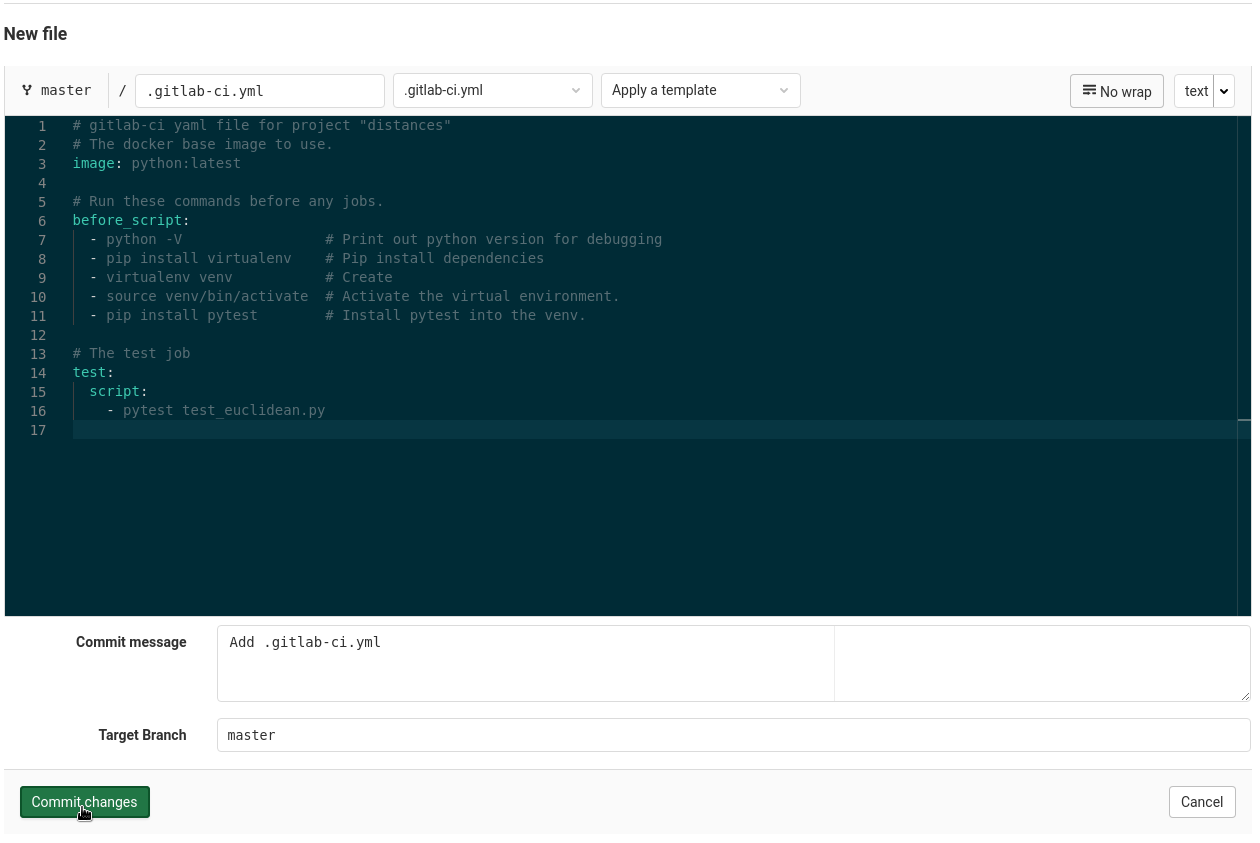

Finalize the CI configuration by committing the changes to your repository. Provide a commit message and click the "Commit changes" button.

Since CI is activated (see above), this commit will trigger the first CI run. Check the process by navigating to `CI/CD`. 

After the test is finished, you will see a test report page, similar to this one (it will look differently if the test failed...)

![Screenshot_2020-12-07_20-40-16.png](static/CI.png)

Now let's try out the automated test feature. We will implement an additional distance, the Manhattan distance. But this time, we'll do it the pro way:  We will *first* add a test function for the new distance metric. Naturally, the test will fail. Subsequently, we will implement the new distance such that the test passes. This approach is called *test driven development* and is an established technique in software engineering.
The value of writing the test first is that we have to get a very clear idea of the expected behaviour of our new function, even before we start implementing it. If we were given a list of requirements from our supervisor, we could add a test function for each requirement and then implement the code such that one test after the other succeeds. In the end, all requirements would be satisfied.

## Exercises
0. Make "atomic" commits, i.e. one change per commit.
1. Update your local repository's master branch (`git pull`).
1. Create and checkout a new branch named "manhattan".
1. Copy the file `test_euclidean.py` to a new file `test_manhattan.py`
1. Implement the test using the same pair of vectors as in `test_euclidean.py`. What is the expected Manhattan distance between vectors $u$ and $v$?
1. Run the new test and observe the test failure.
1. Implement the Manhattan distance in a new file `distances/manhattan.py`.
1. Add the new module to the distances package (Hint: Edit `distances/__init__.py`
1. Add the new test to the CI configuration.

## Solutions:
1. Update
    ```shell
    git checkout master
    git pull origin master
    ```

1. New branch off master
    ```shell
    git branch manhattan
    git checkout manhattan
    ```

1. Copy 
    ```shell
    cp test_euclidean.py test_manhattan.py
    git add test_manhattan.py
    git commit
    ```

1. Implement the test in `test_manhattan.py`:

    ```python
    import distances

    def test_manhattan():
        """ Test the manhattan distance calculation. """
        u = (2, -1)
        v = (-2, 2)

        assert distances.manhattan_distance(u, v) == 7.0
    ```  
    ```shell
    git add
    git commit

1. Run the test
    ```shell 
    pytest test_manhattan.py
    ```

    As expected, the test will fail because the `distances` package has no definition of the `manhattan_distance()` function that is called in the `test_manhattan` test function.

1. Implement the new distance function.

    ```python
    # distances/manhattan.py
    import math 

    def manhattan_distance(u, v):
        """
        Computes the Manhattan distance between two vectors `u` and `v`.

        The Euclidean distance between `u` and `v`, is defined as:

        |u_1 - v_1| + ... + |u_n - v_n|

        Parameters
        ----------
        u : list
            Input vector.
        v : list
            Input vector.

        Returns
        -------
        manhattan : double
            The Manhattan distance between vectors `u` and `v`.
        """
        distance = 0

        for u_i, v_i in zip(u, v):
            distance += abs(u_i - v_i)**2

        return distance
    ```
    ```shell
    git add distances/manhattan.py
    git commit
    ```
1. Add to package
    ```python
    # distances/__init__.py

    from .euclidean import euclidean_distance
    ```
   
1. Edit `.gitlab-ci.yml`:
    ```yml
    # gitlab-ci yaml file for project "distances"
    # The docker base image to use.
    image: python:latest

    # Run these commands before any jobs.
    before_script:
      - python -V                 # Print out python version for debugging
      - pip install virtualenv    # Pip install dependencies
      - virtualenv venv           # Create 
      - source venv/bin/activate  # Activate the virtual environment.
      - pip install pytest        # Install pytest into the venv.

    # The test job 
    test:
      script:
        - pytest test_euclidean.py
        - pytest test_manhattan.py
    ```

    



Add the two new files and one modified file to git:
```shell
$ git add test_manhattan.py
$ git add distances/manhattan.py
$ git add distances/__init__.py
```

And commit the changes:
```shell
$ git commit -m "Add manhattan distance and test."
```

**Q:** What is the function of the "-m" flag in the `git commit` command above?

## Register the new test module to CI
Finally, we have to register the new test to the CI system. Edit the file `.gitlab-ci.yml` as follows:

```yml
# gitlab-ci yaml file for project "distances"
# The docker base image to use.
image: python:latest

# Run these commands before any jobs.
before_script:
  - python -V                 # Print out python version for debugging
  - pip install virtualenv    # Pip install dependencies
  - virtualenv venv           # Create 
  - source venv/bin/activate  # Activate the virtual environment.
  - pip install pytest        # Install pytest into the venv.

# The test job 
test:
  script:
    - pytest test_euclidean.py
    - pytest test_manhattan.py
```


Add and commit this change:
```shell
$ git add .gitlab-ci.
$ git commit
```
and push all changes to the remote branch on gitlab:
```
$ git push -u origin implement_manhattan_distance
```

## Check test status on gitlab
Now open your repository website and navigate to the CI summary page (click CI/CD in the navigation panel).

![Screenshot_2020-12-07_21-19-22.png](static/test_gitlab.png)

**What? The test failed!**

Inspecting the test report, we find that the expected result and the result our code gave, do not agree:

![Screenshot_2020-12-07_21-28-30.png](static/failure_gitlab.png)

**Q:** Try to spot the error in `distances/manhattan.py` and fix it. Then recommit to the repository and observe the test run. Iterate this procedure until the test goes through.

# Building the documentation
The CI feature of gitlab not only allows us to run tests. In the `.gitlab-ci.yml`, we can define any number of "jobs" that will be run sequentially in a "pipeline". Typically, a complete CI pipeline consists of
* Installing dependencies
* Building the code
* Running the tests
* Building the documentation
* Prepare a software package for the users to download

Here, we will demonstrate how to build a reference manual for our code. 

The reference manual will be built based on the information we put into the docstrings of our functions in our python modules. Take a look at `distances/euclidean.py`:

```python
# distances/euclidean.py

import math 

def euclidean_distance(u, v):
    """
    Computes the Euclidean distance between two vectors `u` and `v`.

    The Euclidean distance between `u` and `v`, is defined as:

    \sqrt{(u_1 - v_1) ^ 2 + ... + (u_n - v_n) ^ 2}

    Parameters
    ----------
    u : list
        Input vector.
    v : list
        Input vector.

    Returns
    -------
    euclidean : double
        The Euclidean distance between vectors `u` and `v`.
    """
    distance = 0

    for u_i, v_i in zip(u, v):
        distance += (u_i - v_i) ** 2

    return math.sqrt(distance)


```

The part between a pair of triple-\"\"\" is the docstring. It describes what the function does and the type of input parameters as well as the return type.

This docstring can be parsed by special documentation builders and turned into a reference manual document. The output can be saved as a html document (online documentation) or as a pdf. Finally, we will see how this process can be run as a CI job and the documentation be served as a website on gitlab.

## Install and configure sphinx
The documentation parser is called `sphinx` and can be installed through anaconda. On the command line, run

```shell
$ conda install sphinx
```

or use your system's anaconda GUI.

As always, we will work in a separate branch:
```shell
$ git checkout -b doc
```

Create a new `doc` directory under the repository root directory,

```shell
$ mkdir doc
```

Your repository directory tree should look like this:

```
|--- .git/
|--- distances/
    |--- euclidean.py
    |--- manhattan.py
    |--- __init__.py
|--- doc/
|--- test_euclidean.py
|--- test_manhattan.py
|--- .gitingore
|--- .gitlab-ci.yml
|--- LICENSE   
|--- README.md
```

Change into the new directory
```shell
$ cd doc
```

To configure the documentation builder `sphinx`, use the quick-conf utility:

```shell
$ sphinx-quickstart
```

Answer the questions as follows:
```
> Separate source and build directories (y/n) [n]: y
> Project name: Distances
> Author name(s): <YOUR_NAME_HERE>
> Project release []: 
> Project language [en]: 
```

The `sphinx-quickstart` has created a number of new file in the current working directory:
```shell
$ ls -l
build/  make.bat  Makefile  source/
```

The files `Makefile` and `make.bat` contain all the detailled instruction for your systems `make` utility to actually build the documentation. We don't have
to worry about these files. The directory `source/` will contain all the *static* source files from which to build the documentation. Finally, the build documentation
will be saved under the `build/` directory.

Next, `cd` into the `source/` directory:

```shell
$ cd source
```

And open the file `conf.py` in your editor. Locate the section heading `#-- Path setup ---...` and change the code below:
```python
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from distances import *
```

This adds our `distances` package to the documentation system.

Further down, under `#-- General configuration -- ...`, add the `autodoc` extension:

```python
extensions = [
        "sphinx.ext.autodoc",
        "sphinx.ext.napoleon",
        
]
```
The `autodoc` extension is responsible for parsing the docstrings an formatting them into a reference manual. The `napoleon` extension adds support for
 Google and numpy documentation syntax used in our code (see [this link](https://www.sphinx-doc.org/en/master/usage/extensions/napoleon.html#module-sphinx.ext.napoleon)) for more info.
 
Save and close the file.

## Manually building the documentation
At this point, we can already build the skeleton of our documentation, i.e. the layout and general markup. There is no content yet...

Change back to the parent directory
```shell
$ cd ..
```

and run the command
```shell
$ make html
```

This will build the documentation website html document and save it under `build/html`. You can open the page by running 

<a name="python_web_server"></a>
```shell
$ python -m http.server --directory build/html
```
Then open the website http://localhost:8000 in your browser.



You should see a static website similar to this:

![Screenshot_2020-12-08_10-35-20.png](static/docs_header.png)

## Adding the documentation content
Now it's time to add some content to our documentation and link in the docstrings from the code.

The file `doc/source/index.rst` is the root document of the documentation. It is formatted in the `ReStructuredText` markup language. E.g. top level headings are underlined
by `===`, directives start with `..` and so on. See the [ReStructuredText manual](https://www.sphinx-doc.org/en/master/usage/restructuredtext/basics.html) for details.
To add our modules' documentation, we first have to convert their docstrings into `ReStructuredText`:
From the `doc/` directory, run

```shell
$ sphinx-apidoc -f -o source ../distances
```

This will create two new files in the `source/` directory, `modules.rst` and `distances.rst`. These contain the formatted version of our docstrings. 
Now, we can easily include the distances documentation in the `index.rst` by adding one line after the `.. toctree` directive. Your `index.rst` should look like this:

```rst
.. doc/source/index.rst

Welcome to Distances's documentation!
=====================================

.. toctree::
   :maxdepth: 2
   :caption: Contents:

   distances


Indices and tables
==================

* :ref:`genindex`
* :ref:`modindex`
* :ref:`search`
```

Build the documentation again:

```shell 
$ make html
```

Reload the documentation website at http://localhost:8000 (supposing that the webserver is still running, otherwise restart it, [see above](#python_web_server)).

You should now see a beautiful documentation website similar to this one:

![Screenshot_2020-12-08_11-12-51.png](static/docs.png)

Take some time to browse around your documentation site and try to mentally connect the contents of the `.rst` files and the elements and links in the webpage.

## Let gitlab-CI build the documentation: gitlab-pages
So far we have *manually* built the documentation. What we want is that each time the code and/or the documentation changes, the manual is rebuilt to reflect these
changes. We need to define a new CI job in our pipeline.

Change back to the repository root directory and edit the file `.gitlab-ci.yml`.

```yml
# gitlab-ci yaml file for project "distances"
# The docker base image to use.
image: python:latest

# Run these commands before any jobs.
before_script:
  - python -V                 # Print out python version for debugging
  - pip install virtualenv    # Pip install dependencies
  - virtualenv venv           # Create 
  - source venv/bin/activate  # Activate the virtual environment.
  - pip install pytest        # Install pytest into the venv.
  - pip install sphinx        # Install pytest into the venv.

# The test job 
test:
  script:
    - pytest test_euclidean.py
    - pytest test_manhattan.py

pages:
  script:
    - cd doc
    - sphinx-apidoc -f -o source ../distances
    - make html
    - cp -av build/html ../public
  artifacts:
    paths:
      - public
```
We add the `pages` job at the end. It contains all steps to take to build the documentation. The last step is to copy the built documentation website to a directory `pages` under the repository root. The `artifacts` directive ensures that
the `public` directory will be maintained when the site is exposed through a webserver.

## Push to gitlab
We have now configured our repository to automatically build the reference manual. Let's add all needed new files to git and push to gitlab.

```shell
$ git add doc/Makefile
$ git add doc/make.bat
$ git add doc/source/conf.py
$ git add doc/source/index.rst
$ git add .gitlab-ci.yml

$ git commit
$ git push -u origin doc
```
The last command pushes our changes to a new remote branch `doc`.

Observe the status of your CI pipeline under CI/CD -> Pipelines. Note that the pipeline now contains two Jobs, one for testing and one for building the documentation.
After the second job succeeds, you should be able to open your online documentation site at http://<YOUR_GITLAB_USERNAME>.pages.gwdg.de/distances. 

## Build documentation only for the master branch
To make sure that the documentation is built only on the master branch, we add one more directive to `.gitlab-ci.yml`:

```yml
# gitlab-ci yaml file for project "distances"
# The docker base image to use.
image: python:latest

# Run these commands before any jobs.
before_script:
  - python -V                 # Print out python version for debugging
  - pip install virtualenv    # Pip install dependencies
  - virtualenv venv           # Create 
  - source venv/bin/activate  # Activate the virtual environment.
  - pip install pytest        # Install pytest into the venv.
  - pip install sphinx        # Install pytest into the venv.

# The test job 
test:
  script:
    - pytest test_euclidean.py
    - pytest test_manhattan.py

pages:
  script:
    - cd doc
    - sphinx-apidoc -f -o source ../distances
    - make html
    - cp -av build/html ../public
  artifacts:
    paths:
      - public
  only:
    - master
```

Add, commit, and push again and then create a merge request to merge the `doc` branch into `master`. Note that the CI pipeline is also run on the Merge request, so you
can detect possible issues already before the final merge.





## Add test and documentation badges to README

As a final gimmick, let's be hip and show off our test status on the repository's front page. Follow these steps:

* Navigate to your project’s Settings > General > Badges.
* Under Name, enter Pipeline Status.
* Under Link, enter the following URL: https://gitlab.com/%{project_path}/-/commits/%{default_branch}
* Under Badge image URL, enter the following URL: https://gitlab.com/%{project_path}/badges/%{default_branch}/pipeline.svg
* Submit the badge by clicking the Add badge button.

The pipeline status badge will then appear on top of the repository's front page: